# CMPSC 445 - M7 Assignment

### Loading Data
MNIST Dataset

In [3]:
from torchvision import datasets, transforms

# defining preprocessing transformations on mnist dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# loading mnist training data
mnist_training_data = datasets.MNIST(
    './data/mnist', 
    train=True, 
    download=True,
    transform=transform
)

# loading mnist test data
mnist_testing_data = datasets.MNIST(
    './data/mnist', 
    train=False, 
    transform=transform
)

### Define Model

Involves:
- Initialization
- Forward Propagation
- Training Function
- Testing Function
- Model Training Function

In [4]:
import torch
from torch import nn as nn

class NeuralNet(nn.Module):
    """  
    Neural network model for classification tasks.

    This model consists of two hidden layers with ReLU activation 
    and an output layer that uses log softmax for multi-class classification.

    Attributes:
        fc1 (nn.Linear): The first fully connected hidden layer (input: 784, output: 128).
        fc2 (nn.Linear): The second fully connected hidden layer (input: 128, output: 64).
        final_layer (nn.Linear): The final layer for output (input: 64, output: 10).
    
    """
    def __init__(self):
        super().__init__()

        # hidden layers with ReLU activations
        # first fully connected hidden layer (input: 784, output: 128)
        self.fc1 = nn.Linear(28*28, 128)
        # second fully connected hidden layer (input: 128, output: 64)
        self.fc2 = nn.Linear(128, 64)
        # final layer (output: 10 for classification, assuming 10 classes)
        self.final_layer = nn.Linear(64, 10)

    def forward(self, x):
        # flatten input image (assuming input is of shape [batch_size, 1, 28, 28])
        x = x.view(-1, 28*28)

        # pass through hidden layers with ReLU activations
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        # pass through final layer
        output = self.final_layer(x)
        # applying log softmax to the output (for NLL loss)
        output = nn.functional.log_softmax(output, dim=1)

        return output
    
    def training(model, train_dataloader, optimizer, print_freq=10):
        model.train()   # set model to training mode

        train_loss = 0

        for batch_index, (data, target) in enumerate(train_dataloader):
            optimizer.zero_grad()   # zero the gradients
            output = model(data)    # forward pass through the model

            # calculate loss using negative log-likelihood
            loss = nn.functional.nll_loss(output, target)

            # backpropagation
            loss.backward() 

            # update model parameters
            optimizer.step()

            # sum up loss
            train_loss += loss.item() * data.shape[0]

            # print current training loss at specified intervals
            if not (batch_index % print_freq):
                print(
                    f"Train Batch {batch_index}/{len(train_dataloader)} Loss: {loss.item():.4f}"
                )

        # return average training loss
        return train_loss / len(train_dataloader.dataset)
    
    def testing(model, test_dataloader):
        model.eval()    # set model to training mode

        test_loss = 0
        correct = 0

        # no need to compute gradients during evaluation
        with torch.no_grad():
            for data, target in test_dataloader:
                # forward pass through the model
                output = model(data)

                # calculate loss
                test_loss += nn.functional.nll_loss(output, target, reduction='sum').item()

                # get predictions by taking argmax of the output (the class with the highest score)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        # average loss over test dataset
        test_loss /= len(test_dataloader.dataset)

        # calculate accuracy
        test_accuracy = correct / len(test_dataloader.dataset)

        return test_loss, test_accuracy
    
    def train_model(model, train_dataloader, test_dataloader, optimizer, num_epochs):
        # test loss and accuracy after each epoch
        test_loss_lst = []
        test_accuracy_lst = []

        for i in range(num_epochs):
            # train model for one epoch
            train_loss = NeuralNet.training(model, train_dataloader, optimizer)
            
            # test model on validation set
            test_loss, test_accuracy = NeuralNet.testing(model, test_dataloader)
            
            # append to lists
            test_loss_lst.append(test_loss)
            test_accuracy_lst.append(test_accuracy)

            # print stats
            print(
                f"Epoch: {i+1} | Train Loss: {train_loss:.5f} |",
                f"Test Loss: {test_loss:.5f} | Test Accuracy: {test_accuracy:.5f}"
            )

        return test_loss_lst, test_accuracy_lst

# model = NeuralNet()
# print(f"Model: {model}")
# print(f"Parameter Sum: {sum([torch.prod(torch.tensor(i.shape)) for i in model.parameters()])}")

### Training Model

Results Summary:
- Model improved steadily, with both training and test losses decreasing and test accuracy rising consistently.
The model is generalizing well to the test data, evidenced by a strong performance on the test set.
- The absence of signs of overfitting (i.e., test accuracy keeps improving without a significant rise in test loss) suggested a well-balanced model.
- The results indicated that the model would be on track and likely to perform well in real-world scenarios.

Model Output Training Statistics:
| Epoch | Train Loss | Test Loss | Test Accuracy |
| :----: | :---------: | :--------: | :------------: |
| 1     | 0.32063    | 0.15165      | 0.95537       |
| 2     | 0.13151    | 0.09308      | 0.97242       |
| 3     | 0.09001    | 0.06999      | 0.97922       |
| 4     | 0.06998    | 0.05546      | 0.98257       |
| 5     | 0.05499    | 0.03792      | 0.98860       |
| 6     | 0.04414    | 0.03082      | 0.99087       |
| 7     | 0.03761    | 0.02451      | 0.99242       |
| 8     | 0.02950    | 0.02248      | 0.99293       |
| 9     | 0.02404    | 0.01487      | 0.99523       |
| 10    | 0.02402    | 0.02228      | 0.99182       |

In [9]:
# dataloader for training data
train_dataloader = torch.utils.data.DataLoader(
    mnist_training_data,
    batch_size = 128, 
    shuffle = True
)

# dataloader for testing data
test_dataloader = torch.utils.data.DataLoader(
    mnist_training_data,
    batch_size = 128, 
    shuffle = False
)

# running model train function
model = NeuralNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

test_loss_lst, test_accuracy_lst = NeuralNet.train_model(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    num_epochs=10
)

Train Batch 0/469 Loss: 2.3177
Train Batch 10/469 Loss: 0.7649
Train Batch 20/469 Loss: 0.5529
Train Batch 30/469 Loss: 0.3319
Train Batch 40/469 Loss: 0.3817
Train Batch 50/469 Loss: 0.3438
Train Batch 60/469 Loss: 0.3085
Train Batch 70/469 Loss: 0.3126
Train Batch 80/469 Loss: 0.2026
Train Batch 90/469 Loss: 0.3183
Train Batch 100/469 Loss: 0.1991
Train Batch 110/469 Loss: 0.2404
Train Batch 120/469 Loss: 0.3736
Train Batch 130/469 Loss: 0.1979
Train Batch 140/469 Loss: 0.1698
Train Batch 150/469 Loss: 0.3038
Train Batch 160/469 Loss: 0.3477
Train Batch 170/469 Loss: 0.2129
Train Batch 180/469 Loss: 0.2346
Train Batch 190/469 Loss: 0.2448
Train Batch 200/469 Loss: 0.3017
Train Batch 210/469 Loss: 0.2245
Train Batch 220/469 Loss: 0.2633
Train Batch 230/469 Loss: 0.1715
Train Batch 240/469 Loss: 0.2743
Train Batch 250/469 Loss: 0.3023
Train Batch 260/469 Loss: 0.2157
Train Batch 270/469 Loss: 0.1603
Train Batch 280/469 Loss: 0.2761
Train Batch 290/469 Loss: 0.0769
Train Batch 300/469 L

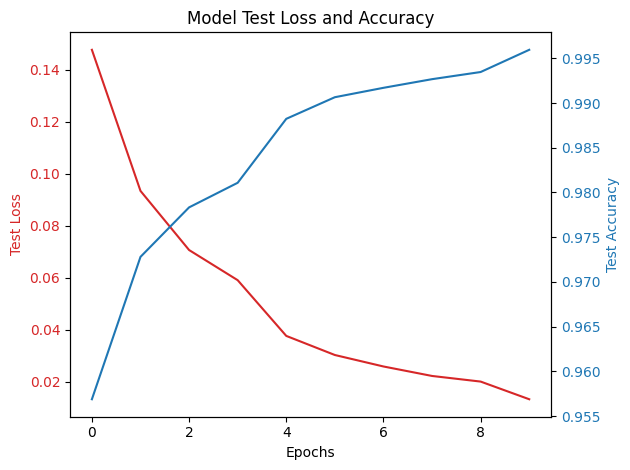

In [8]:
import matplotlib.pyplot as plt

test_loss_lst 
test_accuracy_lst

# Create a figure with two subplots
fig, ax1 = plt.subplots()

# plotting test loss
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Test Loss', color=color)
ax1.plot(test_loss_lst, color=color, label='Test Loss')
ax1.tick_params(axis='y', labelcolor=color)

# second y-axis for test accuracy
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Test Accuracy', color=color)  
ax2.plot(test_accuracy_lst, color=color, label='Test Accuracy')
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Model Test Loss and Accuracy')
fig.tight_layout()  
plt.show()



### Questions

1. How do PyTorch dataloaders work? How do we get the next batch of data and labels from a dataloader? What is the effect of changing the batch_size argument when we create the dataloaders?
<br><br>
PyTorch's DataLoader help the process of loading and batching data for model training by working with a Dataset to fetch samples. One can retrieve batches using a for loop, where each iteration returns a batch of data and its corresponding labels/outputs. The batch_size argument determines how many samples are loaded together: larger batch sizes can speed up training and provide more stable gradient estimates but require more memory, while smaller batch sizes are memory-efficient and can enhance generalization due to noisier updates, albeit at the cost of slower convergence.

2. How does the log loss work? Explain in your own words. Why is this a good loss function for the classification task we want to perform?
<br><br>
Log loss, a.k.a cross-entropy loss, is a loss function commonly used for binary and multi-class classification tasks. It measures the performance of a classification model whose output is a probability value between 0 and 1. Essentially, it punishes incorrect predictions more heavily than correct ones. If the predicted probability is far from the actual target, the loss increases significantly, guiding the model to improve its predictions. Mathematically, it can be expressed as the following:

$$ LogLoss(y, p) = -\frac{1}{N} \sum^{N}_{i=1} [y_i log(p_i)  +  (1 - y_i)log(1 - p_i)] $$ 

- It is a very good choice for classification because it measures how well a model predicts probabilities for each class, allowing for a clear interpretation of confidence in predictions by promoting better accuracy. Additionally, log loss handles class imbalance effectively by focusing on the true class's predicted probabilities, provides smooth gradients for easier optimization, and helps well-calibrated probabilities, enhancing the model's ability to generalize to new data.




    


3. What activation function did you use in your network? Can you explain what the activation function does to its inputs?

    ReLU (Rectified Linear Unit) is an activation function : $ ReLU(x) = max(0,x) $

    It outputs the input directly if positive and zero otherwise, introducing non-linearity and enabling the model to infer complex patterns.

    Benefits of ReLU in the Models:
    - Mitigation of Vanishing Gradient: ReLU helps prevent the vanishing gradient problem, allowing for better gradient flow during backpropagation, which accelerates training.<br><br>
    - Computational Efficiency: The simple thresholding operation makes ReLU computationally efficient, speeding up calculations and improving overall model performance.<br><br>
    - Sparsity: By setting negative values to zero, ReLU introduces sparsity in activations, which can enhance model efficiency and help focus learning on significant features.

4. What happened to the model test loss and accuracy as it was trained? Modify the train_model() function to return a list containing the test loss and accuracy after each epoch, use them to generate a plot of the model test loss and accuracy using matplotlib once training is done, and paste the plot here.

    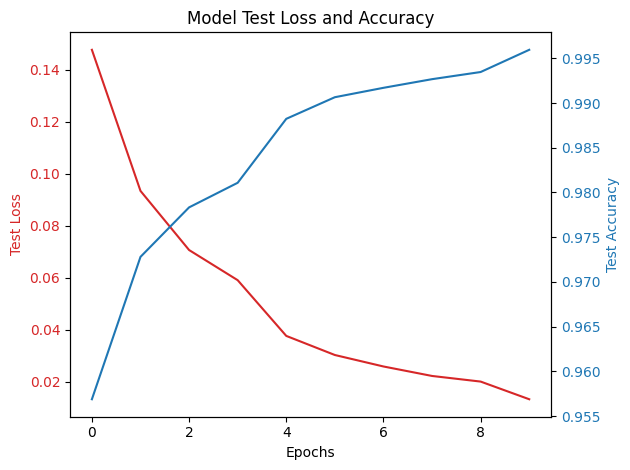



5. What does the lr parameter you pass in when creating the optimizer do? Try training your model with a few different values of lr (0.0001, 0.01, 1). What happens in each case?

    The lr (learning rate) parameter in an optimizer controls the size of the steps taken to minimize the loss during training. 
    - A low learning rate (e.g., 0.0001) results in very slow training, potentially leading to stagnation or excessive epochs before convergence. <br><br>
    - A moderate learning rate (e.g., 0.01 or 0.001) typically provides a balanced approach, allowing the model to learn effectively and steadily improve in performance. <br><br>
    - On the other hand, a high learning rate (e.g., 1) can cause chaos, leading to erratic updates that may result in loss oscillation or divergence, ultimately hindering model training.

